In [241]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt


In [283]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS= 3
EPOCHS = 50

In [284]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
   "PlantVillage",
    seed=123,
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 4500 files belonging to 3 classes.


In [244]:
class_names=dataset.class_names
class_names

['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']

In [245]:
len(dataset)

141

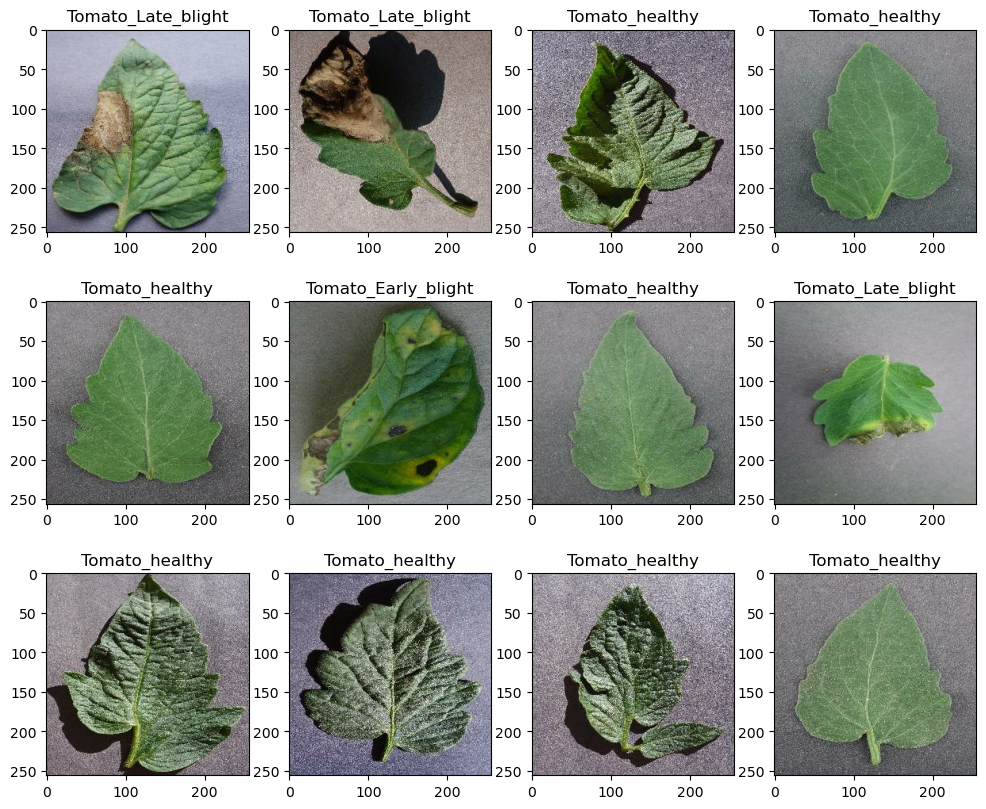

In [246]:
plt.figure(figsize=(12,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
#         plt.axis("off")

In [247]:
train_size=0.8
len(dataset)*train_size

112.80000000000001

In [248]:
train_ds=dataset.take(112)
len(train_ds)


112

In [249]:
test_ds=dataset.skip(112)
len(test_ds)

29

In [250]:
val_size=0.1
len(dataset)*val_size

14.100000000000001

In [251]:
val_ds=test_ds.take(14)
len(val_ds)

14

In [252]:
test_ds=test_ds.skip(14)
len(test_ds)

15

In [253]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size=len(ds)
    
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
        
    
    
    train_size=int(train_split * ds_size)
    val_size=int(val_split * ds_size)
    
    train_ds=ds.take(train_size)
    
    val_ds=ds.skip(train_size).take(val_size) 
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds 


In [254]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [255]:
len(train_ds)

112

In [256]:
len(val_ds)

14

In [257]:
len(test_ds)

15

In [258]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [259]:
resize_and_rescale = tf.keras.Sequential([
        layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
        layers.experimental.preprocessing.Rescaling(1./255)
])

In [260]:
data_augmentation=tf.keras.Sequential([
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        layers.experimental.preprocessing.RandomRotation(0.2)
])

In [261]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [262]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)), 
    layers.Flatten( ),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])
model.build(input_shape=input_shape)


In [263]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_19 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 sequential_20 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 conv2d_48 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_48 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_49 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_49 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                               

In [285]:
model.compile(
   optimizer='adam',
   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
   metrics=['accuracy']
   
)

In [286]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/50
112/112 [==============================] - 81s 715ms/step - loss: 0.2299 - accuracy: 0.9076 - val_loss: 0.3475 - val_accuracy: 0.8527
Epoch 2/50
112/112 [==============================] - 81s 721ms/step - loss: 0.1761 - accuracy: 0.9286 - val_loss: 0.4104 - val_accuracy: 0.8438
Epoch 3/50
112/112 [==============================] - 83s 739ms/step - loss: 0.1758 - accuracy: 0.9314 - val_loss: 0.2448 - val_accuracy: 0.9286
Epoch 4/50
112/112 [==============================] - 82s 727ms/step - loss: 0.1684 - accuracy: 0.9356 - val_loss: 1.1221 - val_accuracy: 0.8013
Epoch 5/50
112/112 [==============================] - 82s 732ms/step - loss: 0.1664 - accuracy: 0.9328 - val_loss: 1.9029 - val_accuracy: 0.7121
Epoch 6/50
112/112 [==============================] - 84s 750ms/step - loss: 0.1350 - accuracy: 0.9513 - val_loss: 1.0605 - val_accuracy: 0.8058
Epoch 7/50
112/112 [==============================] - 193s 2s/step - loss: 0.1500 - accuracy: 0.9418 - val_loss: 1.6346 - val_accu

In [287]:
scores = model.evaluate(test_ds)

15/15 [==============================] - 4s 246ms/step - loss: 0.1194 - accuracy: 0.9729


In [289]:
scores

[0.11936227232217789, 0.9729166626930237]

In [291]:
history

In [292]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 112}

In [293]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [294]:
type(history.history['loss'])


list

In [295]:
len(history.history['loss'])

50

In [296]:
history.history['loss'][:5]

[0.22991445660591125,
 0.17612339556217194,
 0.17583510279655457,
 0.16839176416397095,
 0.1664402186870575]

In [298]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

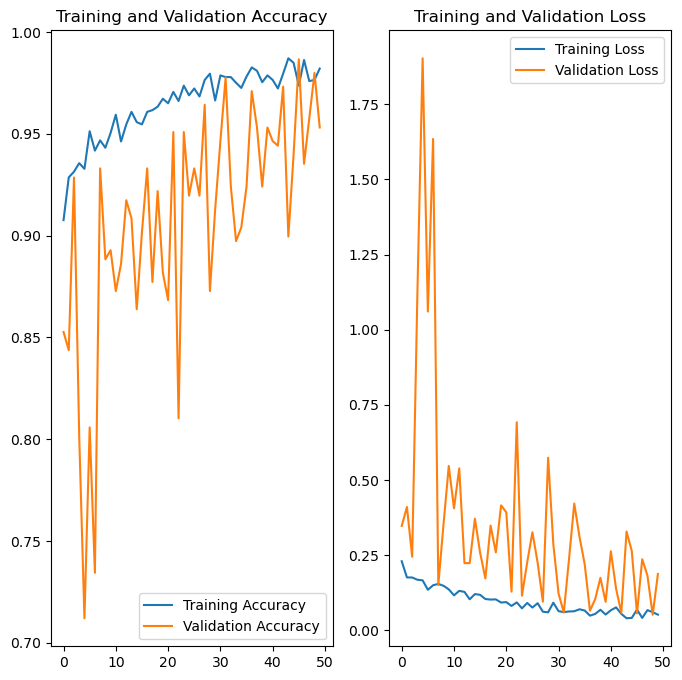

In [299]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


first image to predict
actual label: Tomato_Late_blight
1/1 [==============================] - 0s 310ms/step
predicted label: Tomato_Late_blight


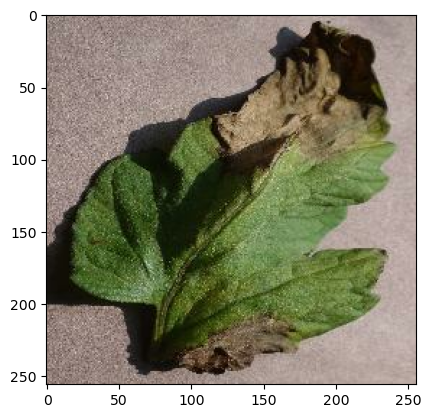

In [300]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [301]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


1/1 [==============================] - 0s 16ms/step


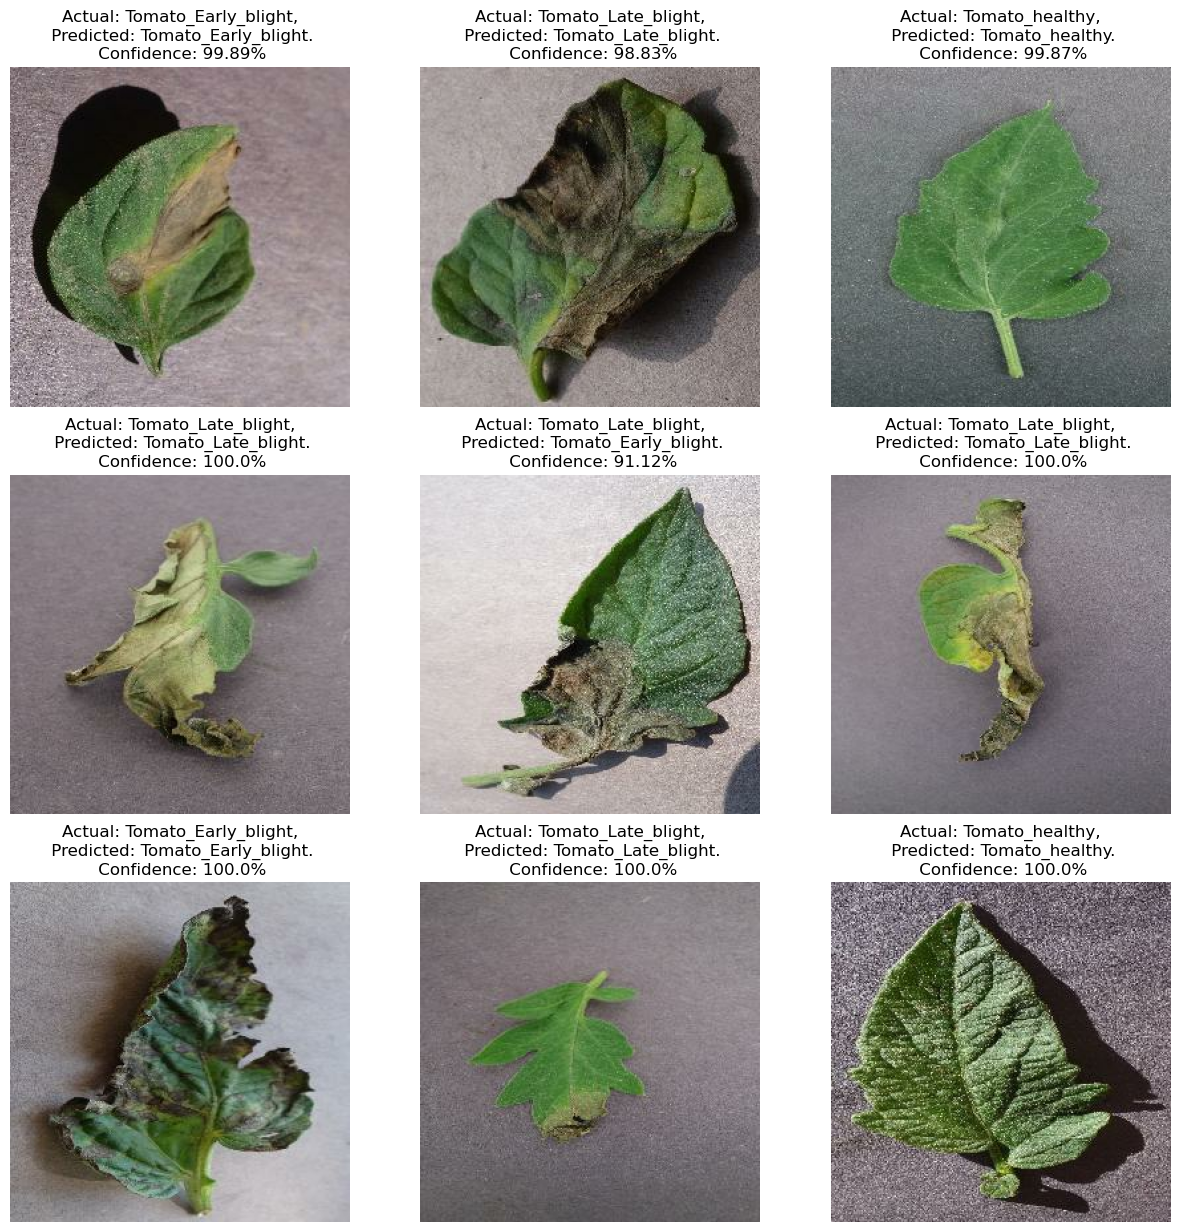

In [302]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [282]:
# import os
# model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
# model.save(f"../models/{model_version}")

FileNotFoundError: [Errno 2] No such file or directory: '../models'